Paper: Siamese Neural Networks for One-shot Image Recognition
http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

Images sizes: 40x40 / 75x75 / 105x105 / 120x120 / 150x150
Images in RGB / Grayscale

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from helper_functions import create_tf_data_datasets_contrastive
from helper_functions import plot_training

## Original Model

In [61]:
anchor_images_path = "npz_datasets/pairs_30k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_30k_224_224/positive"
width, height, channels = 105, 105, 3
batch_size = 128
train_dataset, val_dataset = create_tf_data_datasets_contrastive(anchor_images_path, positive_images_path, height, width, batch_size, rgb=True)

In [62]:
def get_original_model(height, width, channels):

    input = keras.layers.Input(shape=(height, width, channels))

    x = keras.layers.Conv2D(64, (10,10), activation="relu",
                            kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                            bias_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                            kernel_regularizer=keras.regularizers.l2(2e-4))(input)
    x = keras.layers.MaxPooling2D(2,2)(x)

    x = keras.layers.Conv2D(128, (7,7), activation="relu",
                            kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                            bias_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                            kernel_regularizer=keras.regularizers.l2(2e-4))(x)
    x = keras.layers.MaxPooling2D(2,2)(x)

    x = keras.layers.Conv2D(128, (4,4), activation="relu",
                        kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        kernel_regularizer=keras.regularizers.l2(2e-4))(x)
    x = keras.layers.MaxPooling2D(2,2)(x)

    x = keras.layers.Conv2D(256, (4,4), activation="relu",
                        kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        kernel_regularizer=keras.regularizers.l2(2e-4))(x)

    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(4096, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.2),
                           bias_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                           kernel_regularizer=keras.regularizers.l2(1e-3))(x)

    model = keras.models.Model(input, output)

    return model

In [63]:
original_model = get_original_model(height,width,channels)

In [64]:
original_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 128)         0   

In [65]:
left_input = keras.layers.Input(shape=(height, width, channels))
right_input = keras.layers.Input(shape=(height, width, channels))

encoded_l = original_model(left_input)
encoded_r = original_model(right_input)

L1_layer = keras.layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
merge_layer = L1_layer([encoded_l, encoded_r])

prediction = keras.layers.Dense(1, activation="sigmoid")(merge_layer)

original_siamese_model = keras.models.Model([left_input, right_input], outputs=prediction)

In [66]:
original_siamese_model.compile(loss="binary_crossentropy",
                               optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.5), metrics=["accuracy"])

In [ ]:
history_original_siamese_model = original_siamese_model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
166/166 [==============================] - 15s 79ms/step - loss: 1509.9143 - accuracy: 0.5129 - val_loss: 1508.9049 - val_accuracy: 0.5153
Epoch 2/100
166/166 [==============================] - 13s 72ms/step - loss: 1507.9109 - accuracy: 0.5152 - val_loss: 1506.9022 - val_accuracy: 0.5096
Epoch 3/100
166/166 [==============================] - 13s 73ms/step - loss: 1505.9102 - accuracy: 0.5222 - val_loss: 1504.9026 - val_accuracy: 0.5288
Epoch 4/100
166/166 [==============================] - 13s 73ms/step - loss: 1503.9116 - accuracy: 0.5228 - val_loss: 1502.9055 - val_accuracy: 0.5326
Epoch 5/100
166/166 [==============================] - 13s 72ms/step - loss: 1501.9149 - accuracy: 0.5364 - val_loss: 1500.9100 - val_accuracy: 0.5300
Epoch 6/100
166/166 [==============================] - 13s 73ms/step - loss: 1499.9215 - accuracy: 0.5276 - val_loss: 1498.9170 - val_accuracy: 0.5251
Epoch 7/100
166/166 [==============================] - 13s 72ms/step - loss: 1497.9290 - accur

In [70]:
original_siamese_model.evaluate(val_dataset)

42/42 [==============================] - 2s 24ms/step - loss: 1322.8503 - accuracy: 0.7868


[1322.850341796875, 0.7867646813392639]

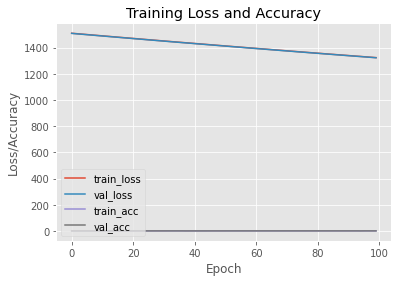

In [71]:
plot_training(history_original_siamese_model)